In [1]:
import numpy as np
from TMDP import TMDP
from River_swim import River

#from algorithms import *
from PG_algorithms import *
from model_functions import *
import gym
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import functional as F

#np.set_printoptions(precision=4)
import math
from utils import *
from ActorCritic import *
from ReplayBuffer import ReplayBuffer

nS = 10
nA = 2
seed = get_current_seed()
seed = 44697628841978080856580175700798794719
gamma = .9
mu = np.ones(nS) * 1/nS
river = River(nS, mu, small=5, large=1000, seed=seed)
tau = 1.
xi = np.ones(nS) * 1/nS
tmdp = TMDP(river, xi, tau=tau, gamma=gamma, seed=seed)
mdp = TMDP(river, xi, tau=0., gamma=gamma, seed=seed)
tmdp_1 = TMDP(river, xi, tau=.5, gamma=gamma, seed=seed)


Current seed for result reproducibility: 279448955339602318355000264086417676581


In [2]:
rep_buffer = ReplayBuffer(max_size=int(10e5), input_shape=(1,), seed=seed)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ref_policy = ActorNet(nS, nA, hidden_dim=64).to(device)
policy_pi = ActorNet(nS, nA, hidden_dim=64).to(device)

v_net = ValueNet(nS, hidden_dim=64).to(device)
q_net = QNet(nS, nA, hidden_dim=64).to(device)

In [4]:
pol_opt = torch.optim.AdamW(ref_policy.parameters(), lr=1e-3)
v_opt = torch.optim.AdamW(v_net.parameters(), lr=1e-3)
q_opt = torch.optim.AdamW(q_net.parameters(), lr=1e-3)


In [5]:

tmdp.update_tau(0.6)
tmdp.reset()
cur_res = curriculum_AC_NN(tmdp, policy_pi, ref_policy, v_net, q_net,
                           pol_opt, v_opt, q_opt, rep_buffer, 
                           alpha=.02, alpha_u=.02, episodes=150000, 
                           batch_size=4, biased=False)

Value Loss:  2.026451587677002
Q Loss:  2.7697932720184326
Policy Loss:  -0.09093543887138367
[(0.08067, 0.6), (0.0, 0.59717), (1.0, 0.6)]
Alpha*: 0.08067 tau*: 0.6 Episode: 86 length: 41 #teleports:46
Got not null reward 20.0!
Time for bound evaluation:  0.03000617027282715
Value Loss:  0.11149057745933533
Q Loss:  0.3787388205528259
Policy Loss:  -0.2655957043170929
[(0.07902, 0.6), (0.0, 0.59722), (1.0, 0.6)]
Alpha*: 0.07902 tau*: 0.6 Episode: 103 length: 4 #teleports:13
Time for bound evaluation:  0.009002685546875
Value Loss:  0.0674281194806099
Q Loss:  0.07191913574934006
Policy Loss:  -0.008050583302974701
[(0.07776, 0.6), (0.0, 0.59731), (1.0, 0.6)]
Alpha*: 0.07776 tau*: 0.6 Episode: 108 length: 4 #teleports:1
Time for bound evaluation:  0.01400303840637207
Value Loss:  0.051964499056339264
Q Loss:  0.02505240961909294
Policy Loss:  -0.09569841623306274
[(0.07457, 0.6), (0.0, 0.59737), (1.0, 0.6)]
Alpha*: 0.07457 tau*: 0.6 Episode: 117 length: 4 #teleports:5
Time for bound eva

In [6]:
print(ref_policy.get_probabilities())
print(q_net.get_values())

[[5.00530779e-01 4.99469221e-01]
 [4.99736011e-01 5.00263929e-01]
 [4.99917656e-01 5.00082374e-01]
 [5.00327826e-01 4.99672204e-01]
 [4.99965161e-01 5.00034869e-01]
 [5.00054777e-01 4.99945253e-01]
 [5.00023901e-01 4.99976128e-01]
 [5.00380933e-01 4.99619097e-01]
 [5.00301659e-01 4.99698311e-01]
 [2.94292195e-15 1.00000000e+00]]
[[ 5.00407457e+00  9.32249129e-02]
 [ 3.23551804e-01  2.65449584e-02]
 [-1.31921172e-02 -5.46637177e-03]
 [-1.24096014e-02  1.68832242e-02]
 [-1.60815902e-02 -3.29277813e-02]
 [-8.41375068e-03 -1.54505968e-02]
 [-8.62501934e-03 -6.49638474e-02]
 [-2.97140665e-02  4.21619713e-02]
 [-1.96727104e-02  2.13088970e+01]
 [ 1.76629469e-01  1.30128952e+02]]


In [7]:
res = bellman_optimal_q(tmdp.env.P_mat, tmdp.env.reward, tmdp.gamma)
Q = res["Q"]

d = compute_d_from_tau(tmdp.env.mu, tmdp.env.P_mat, tmdp.xi, get_policy(Q), tmdp.gamma, 0.)
d_curr = compute_d_from_tau(tmdp.env.mu, tmdp.P_mat_tau, tmdp.xi, get_policy(ref_policy.get_probabilities()), tmdp.gamma, 0.)

print(get_policy(Q))
print(get_policy(ref_policy.get_probabilities()))

r_s_a = compute_r_s_a(tmdp.env.P_mat, tmdp.env.reward)

j_opt = compute_j(r_s_a, get_policy(Q), d, tmdp.gamma)
j_curr = compute_j(r_s_a, get_policy(ref_policy.get_probabilities()), d_curr, tmdp.gamma)
print("optimal performance: ",j_opt, "curriculum performance: ",j_curr)

[[1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
[[1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]
optimal performance:  301.78608999693387 curriculum performance:  49.340959379487096


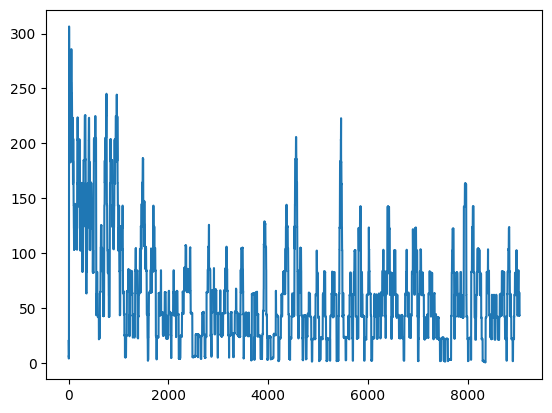

In [8]:
import matplotlib.pyplot as plt
reward_records = cur_res["reward_records"]
# Generate recent 50 interval average
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 50:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-49:idx+1]
    average_reward.append(np.average(avg_list))
# Plot
#plt.plot(reward_records)
plt.plot(average_reward)
